In [2]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import skew
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

full_data = pd.concat([train, test])

#dataset = dataset.rename(columns={'Open Date': 'OpenDate'})
#dataset = dataset.sort_values(by='Open Date')
#train = train.sort_values(by='Open Date')
full_data['City Group'][0]
full_data['P1'][0]
#test.sort_values(by='OpenDate')

0    4
0    1
Name: P1, dtype: int64

In [4]:
drop_elements = ['City','Id']
full_data = full_data.drop(drop_elements, axis = 1)
full_data.head(5)

,City Group,Open Date,P1,P10,P11,P12,P13,P14,P15,P16,...,P36,P37,P4,P5,P6,P7,P8,P9,Type,revenue
0,Big Cities,07/17/1999,4,5,3,5,5.0,1,2,2,...,3,4,4.0,2,2,5,4,5,IL,5653753.0
1,Big Cities,02/14/2008,4,5,1,5,5.0,0,0,0,...,0,0,4.0,1,2,5,5,5,FC,6923131.0
2,Other,03/09/2013,2,5,2,5,5.0,0,0,0,...,0,0,5.0,2,3,5,5,5,IL,2055379.0
3,Other,02/02/2012,6,10,8,10,7.5,6,4,9,...,12,6,6.0,4,4,10,8,10,IL,2675511.0
4,Other,05/09/2009,3,5,2,5,5.0,2,1,2,...,3,3,4.0,2,2,5,5,5,IL,4316715.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001841CDFE240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001841D0F7668>]], dtype=object)

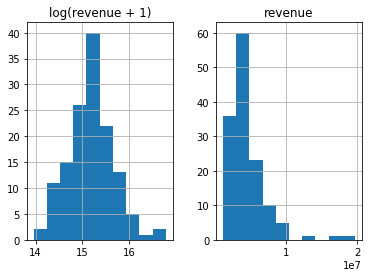

In [5]:
revenue = pd.DataFrame({"revenue":train["revenue"], "log(revenue + 1)":np.log1p(train["revenue"])})
revenue.hist()

In [6]:
full_data["revenue"] = np.log1p(full_data["revenue"])
numeric_feats = full_data.dtypes[full_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

full_data[skewed_feats] = np.log1p(full_data[skewed_feats])

In [7]:
full_data['City Group'] = full_data['City Group'].map( {'Big Cities': 0.0, 'Other': 1.0} ).astype(int)
full_data['Type'] = full_data['Type'].map( {'FC': 0, 'IL': 1, 'DT': 2, 'MB': 3} ).astype(int)
full_data['Open Date'] = full_data['Open Date'].str.split('/').str[2].astype(int)
full_data.head()

,City Group,Open Date,P1,P10,P11,P12,P13,P14,P15,P16,...,P36,P37,P4,P5,P6,P7,P8,P9,Type,revenue
0,0,1999,1.609438,1.791759,1.386294,1.791759,1.791759,0.693147,1.098612,1.098612,...,1.386294,1.609438,1.609438,1.098612,1.098612,5,1.609438,1.791759,1,2.806255
1,0,2008,1.609438,1.791759,0.693147,1.791759,1.791759,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.609438,0.693147,1.098612,5,1.791759,1.791759,0,2.818421
2,1,2013,1.098612,1.791759,1.098612,1.791759,1.791759,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.791759,1.098612,1.386294,5,1.791759,1.791759,1,2.743158
3,1,2012,1.945910,2.397895,2.197225,2.397895,2.140066,1.945910,1.609438,2.302585,...,2.564949,1.945910,1.945910,1.609438,1.609438,10,2.197225,2.397895,1,2.759988
4,1,2009,1.386294,1.791759,1.098612,1.791759,1.791759,1.098612,0.693147,1.098612,...,1.386294,1.386294,1.609438,1.098612,1.098612,5,1.791759,1.791759,1,2.789815


In [41]:
drop_elements = ['P1','P7','P8','P9','P10','P12','P13','P14','P15','P16','P17','P18','P19','P20','P21','P24','P25','P27','P30','P31','P32','P33','P34','P35','P36','P37']
train = train.drop(drop_elements, axis = 1)
test = test.drop(drop_elements, axis = 1)

In [13]:
X_train = full_data[:train.shape[0]]
#X_test = full_data[train.shape[0]:]
#y_test = X_test['revenue']
y = X_train['revenue']
X_train = X_train.drop(['revenue'], axis=1)
#X_test = X_test.drop(['revenue'], axis=1)
#y_test.head()

x_train, x_test, y_train, y_test = train_test_split(X_train, y, test_size=0.25, random_state=0)

x_train.shape, y_train.shape
x_test.shape, y_test.shape
y_test.head(5)

26    2.749458
8     2.798220
86    2.774143
78    2.783103
43    2.761324
Name: revenue, dtype: float64

In [15]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [16]:
model_ridge = Ridge()

In [17]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

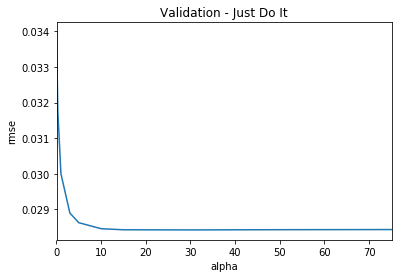

In [18]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [19]:
cv_ridge.min()

0.02842135738832554

In [22]:
Ridge(alpha=100.0).fit(x_train, y_train).score(x_test, y_test)

0.11885502622576793

In [21]:
model_lasso = LassoCV(alphas = [0.05, 0.1, 1, 25, 50, 100, 150,300,600,750,900,1200, 1500]).fit(X_train, y)
rmse_cv(model_lasso).mean()

0.029359111448833398

In [79]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
X_train = full_data[:train.shape[0]]
y_train = X_train['revenue'].ravel()
X_train = X_train.drop(['revenue'], axis=1).values
kf = KFold(n_splits=10)
# kf.get_n_splits(train)

print(kf)
#print(X_train.head(5))
clf = SVR(kernel="linear")
print(cross_val_score(clf, X_train, y_train, cv=35).mean()*100)
for train_index, test_index in kf.split(X_train):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = X_train[train_index], X_train[test_index]
    Y_train, Y_test = y_train[train_index], y_train[test_index]
    clf = Ridge(alpha=100.0).fit(x_train, Y_train)
#     print(clf.score(x_test, Y_test))

#print(x_test,Y_test)

#x_test

KFold(n_splits=10, random_state=None, shuffle=False)
-118.514189888
